In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml # If you don't have this package use 'pip install pyyaml' into commandline or terminal
# Matplotlib Config
%matplotlib inline
plt.style.use('fivethirtyeight')
# Turn 'building.yaml' file into a python dictionary using PyYAML 
with open('building.yaml') as f:
    building_data = f.read()
    building_data = yaml.load(building_data)
    f.close()
building = pd.DataFrame(building_data) #building contains only two rows out of which only one(first one) contains actual info
building = pd.DataFrame(building['building1'][0])
    
### Column Names for our dataframe
col_names = ['sec', 
             'agent_id',
             'agent_type',
             'has_luggage',
             'is_disabled',
             'X', 
             'Y',
             'Z',
             'velocity',
             'queue_id',
             'lookUp_X',
             'lookUp_Y']
df1 = pd.read_csv('Agents/thread_0.txt', header=0, names=col_names)
df2 = pd.read_csv('Agents/thread_1.txt', header=0, names=col_names)
df3 = pd.read_csv('Agents/thread_2.txt', header=0, names=col_names)
df4 = pd.read_csv('Agents/thread_3.txt', header=0, names=col_names)
df5 = pd.read_csv('Agents/thread_4.txt', header=0, names=col_names)
df6 = pd.read_csv('Agents/thread_5.txt', header=0, names=col_names)
df7 = pd.read_csv('Agents/thread_6.txt', header=0, names=col_names)
df8 = pd.read_csv('Agents/thread_7.txt', header=0, names=col_names)

frames = [df1,df2,df3,df4,df5,df6,df7,df8]
df = pd.concat(frames)

In [2]:
#list of all x,y and z points in the building
x_list = []
y_list = []
z_list = []
for i in building.iterrows():
    if i[1]['collision_geometry']['type'] == 'polygon':
        coordinates = i[1]['collision_geometry']['triangles']
    elif i[1]['collision_geometry']['type'] == 'box':
        coordinates = i[1]['config']['position']
    x_list += coordinates[::3]
    y_list += coordinates[1::3]
    z_list += coordinates[2::3] 
#there are 33584 x,y,z coordinates from the building file

In [3]:
max_point = (max(x_list),max(y_list),max(z_list))
min_point = (min(x_list),min(y_list),min(z_list))
(max_point[0] - min_point[0],max_point[1] - min_point[1],max_point[2] - min_point[2])

(281.15, 153.35, 25.5)

In [4]:
agents = df[df['Z']>=0] #taking only the points which have positive Z value
agents.shape

(3830209, 12)

In [5]:
agents.head()

,sec,agent_id,agent_type,has_luggage,is_disabled,X,Y,Z,velocity,queue_id,lookUp_X,lookUp_Y
0,70201,0,4,0.0,0.0,105.955,20.712,7.0,0.586,-1.0,105.500,22.130
1,70201,8,4,0.0,0.0,82.995,14.989,1.0,0.720,-1.0,83.495,18.265
2,70201,16,1,0.0,0.0,49.066,-72.638,1.0,0.737,-1.0,49.822,-72.954
3,70201,24,1,0.0,0.0,111.617,28.309,10.0,2.944,-1.0,108.060,30.175
4,70201,32,1,0.0,0.0,108.920,34.867,4.0,1.386,-1.0,103.980,32.855


In [6]:
xlimt = (min_point[0],max_point[0]+0.001)
ylimt = (min_point[1],max_point[1]+0.001)
zlimt = (min_point[2],max_point[2])
print(xlimt,ylimt,zlimt)

(-139.15, 142.001) (-78.41, 74.941) (0.0, 25.5)


In [7]:
import unittest        
class TreeNode:
    def __init__(self,agents,xlim,ylim,zlim,parent=None,left=None,right=None): #agents is a pandas df
        self.xlim = xlim
        self.ylim = ylim
        self.zlim = zlim #each xlim,ylim and zlim is a tuple denoting limits on each axis
        self.parent = parent
        self.count = self.get_count(agents) #count gets the number of agents for each node
        self.traffic_density = self.get_density()
        self.leftChild = left
        self.rightChild = right
        self.weight = None
            
    def get_count(self,agents): #gets the number of agents within the x,y and z limits
        c = agents[(agents['X']>=self.xlim[0]) & (agents['X']<self.xlim[1]) & (agents['Y']>=self.ylim[0]) & (agents['Y']<self.ylim[1]) & (agents['Z']>=self.zlim[0]) & (agents['Z']<self.zlim[1])].shape[0]
        return c
    
    def get_density(self):  #calculates the space usage per sq. area
        if self.count:
            x = self.xlim[1]-self.xlim[0] #using only x and y axis for area calculation
            y = self.ylim[1]-self.ylim[0]
            z = self.zlim[1]-self.zlim[0]
            volume = (x*y)*z
            return round(self.count/volume,2)
        return None
    
    def split(self,agents,axis): #axis should be either 'x' or 'y' or 'z'
        if axis == 'x':
            mp = round((self.xlim[0]+self.xlim[1])/2,3)  #mp is mid point
            l_xlim = (self.xlim[0],mp)   #l_xlim is lower_x_limit
            u_xlim = (mp,self.xlim[1])   #u_xlim is upper_x_limit
            self.leftChild = TreeNode(agents,l_xlim,self.ylim,self.zlim,parent = self)
            self.rightChild = TreeNode(agents,u_xlim,self.ylim,self.zlim,parent = self)
        elif axis == 'y':
            mp = round((self.ylim[0]+self.ylim[1])/2,3)
            l_ylim = (self.ylim[0],mp)
            u_ylim = (mp,self.ylim[1])
            self.leftChild = TreeNode(agents,self.xlim,l_ylim,self.zlim,parent = self)
            self.rightChild = TreeNode(agents,self.xlim,u_ylim,self.zlim,parent = self)
        elif axis == 'z':
            mp = round((self.zlim[0]+self.zlim[1])/2,1)
            l_zlim = (self.zlim[0],mp)
            u_zlim = (mp,self.zlim[1])
            self.leftChild = TreeNode(agents,self.xlim,self.ylim,l_zlim,parent = self)
            self.rightChild = TreeNode(agents,self.xlim,self.ylim,u_zlim,parent = self)

        return [x for x in [self.leftChild,self.rightChild] if x.count]
    
    def __str__(self):
        s = "Agent Traffic in node : " + str(self.count)
        s += "\n" + "X : " + str(self.xlim) + "\n" + "Y : " + str(self.ylim) + "\n" + "Z : " + str(self.zlim) + "\n" 
        s += "Traffic Density : " + str(self.traffic_density) + " usage/cu.volume" + "\n" 
        s += "Node Weight : " + str(self.weight) + "\n"
        return s

In [8]:
#root initialization
root = TreeNode(agents,xlimt,ylimt,zlimt)  #pass the whole building limits and whole set of agents data into root
print(root)

Agent Traffic in node : 3830203
X : (-139.15, 142.001)
Y : (-78.41, 74.941)
Z : (0.0, 25.5)
Traffic Density : 3.48 usage/cu.volume
Node Weight : None



In [9]:
#recursive code to split building spatially
def building_split(node):
    if node.count < 20000: #this parameter can control the depth of the tree
        return node
    if node.zlim[1]-node.zlim[0] > 2: #check for this bcoz after a few levels z split wont be needed
        for i in node.split(agents,'z'):
            for j in i.split(agents,'x'):
                for k in j.split(agents,'y'):
                    building_split(k) #recursion call
    elif node.xlim[1]-node.xlim[0] > 20: #this parameter can control the node volume
        for j in node.split(agents,'x'):
            for k in j.split(agents,'y'):
                building_split(k) #recursion call
    return node

In [10]:
#function call - runs for a long time - about 10 minutes
building_split(root)

In [11]:
#After the recursive code to split the root is done, root now represents a TREE
#this code is to find out the properties of the tree
import unittest
class btree:
    def __init__(self,root): #root can be root of any tree or subtree
        self.root = root
        self.height,self.no_of_nodes = self.get_height() 
    
    def get_height(self): #get height and total no of non-zero nodes in the tree
        node_list = [self.root]
        child_list = []
        nodes,height = 1,0
        while node_list:
            for i in node_list:
                child_list.extend((i.leftChild,i.rightChild))
            node_list = [x for x in child_list if x is not None and x.count]
            child_list = []
            nodes += len(node_list)
            if node_list:
                height += 1 
        return (height,nodes)
    
    def add_weights(self): #only non-leaf nodes will have weights. Leaf nodes will have None weight
        node_list = [self.root]
        child_list = []
        while node_list:
            for j in node_list:
                if (j.leftChild or j.rightChild) and (j.leftChild.count or j.rightChild.count):
                    w = round((j.leftChild.count - j.rightChild.count)/(j.leftChild.count + j.rightChild.count),2)
                    j.weight = w
                child_list.extend((j.leftChild,j.rightChild))
            node_list = [x for x in child_list if x is not None and x.count]
            child_list = []     
    
    def get_nodes_at_depth(self,depth): #returns the list of nodes at given depth
        node_list = [self.root]
        child_list = []
        for i in range(depth):
            for j in node_list:
                child_list.extend((j.leftChild,j.rightChild))
            node_list = [x for x in child_list if x is not None and x.count]
            child_list = []
        print("The number of occupied nodes at this level is " + str(len(node_list)) + '\n')
        return node_list
    
    def __str__(self):
        s = "This is a binary tree with a height of " + str(self.height) + "\n"
        s += "The number of non-zero nodes in the tree is " + str(self.no_of_nodes) + "\n"
        return s

In [12]:
sim1 = btree(root) #tree for agent simulation 1 
print(sim1.root)
print(sim1)
sim1.add_weights()

Agent Traffic in node : 3830203
X : (-139.15, 142.001)
Y : (-78.41, 74.941)
Z : (0.0, 25.5)
Traffic Density : 3.48 usage/cu.volume
Node Weight : None

This is a binary tree with a height of 12
The number of non-zero nodes in the tree is 1008



In [69]:
#set level for the heat map
level=6
den_x=[]
den_y=[]
den_z=[]
den_val=[]
for i in sim1.get_nodes_at_depth(level):
    den_x.append(min(i.xlim))
    den_y.append(min(i.ylim))
    den_z.append(min(i.zlim))
    den_val.append(i.traffic_density)



  



The number of occupied nodes at this level is 40



In [32]:
import plotly.graph_objs as go
go.Heatmap

plotly.graph_objs.graph_objs.Heatmap

In [64]:
#!pip install colour

In [65]:
#! pip install colorlover

In [66]:
#!pip install plotly

The number of occupied nodes at this level is 40

The number of occupied nodes at this level is 40

The number of occupied nodes at this level is 40

The number of occupied nodes at this level is 40

The number of occupied nodes at this level is 40

The number of occupied nodes at this level is 40



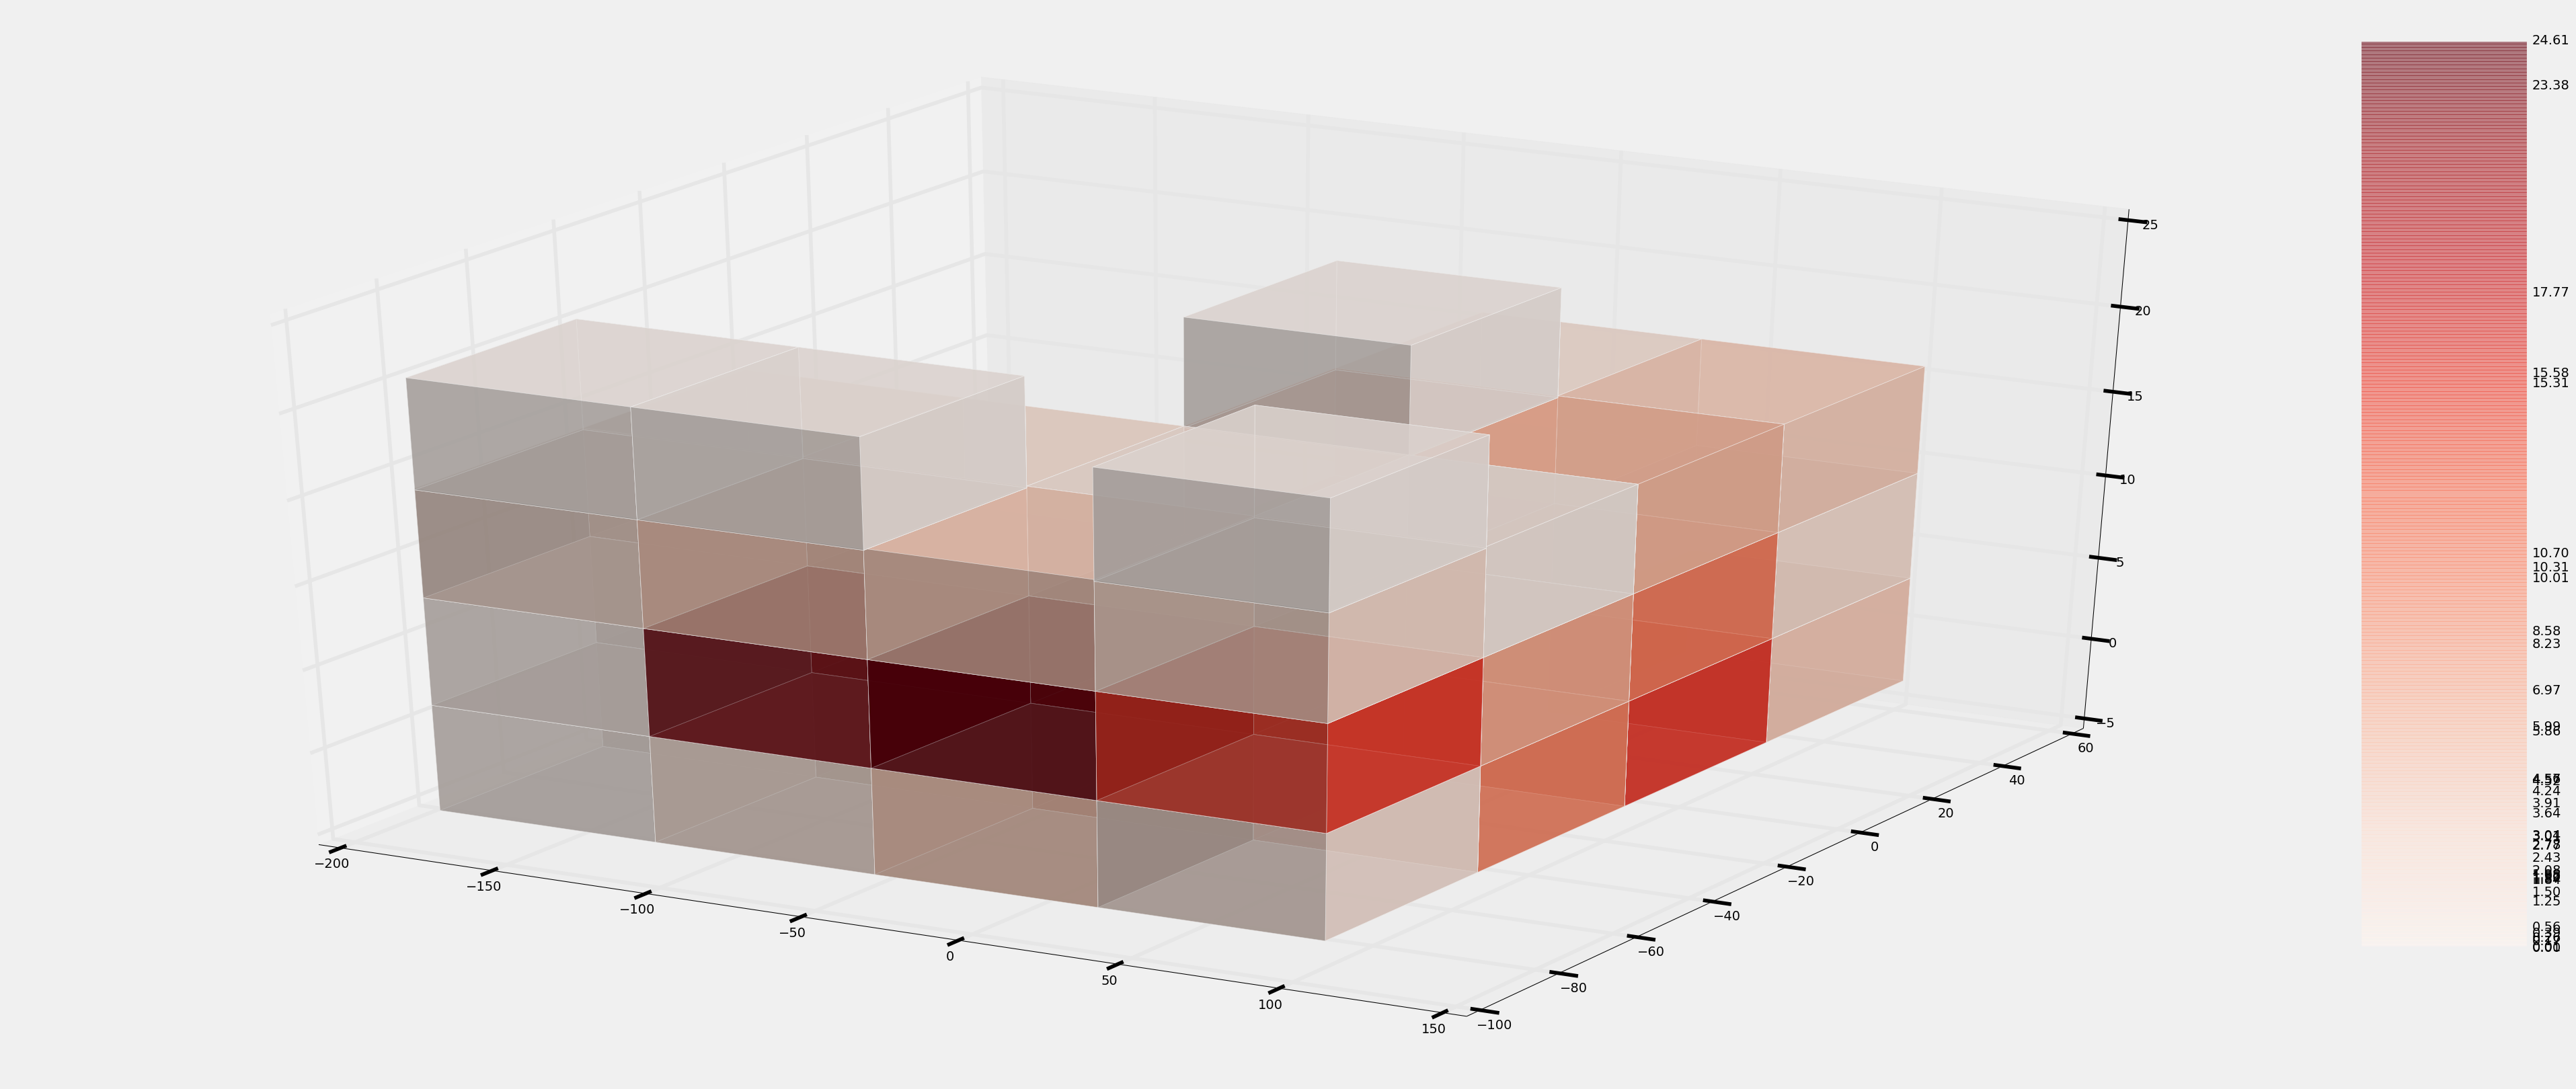

In [73]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colorbar
import matplotlib.colors

def cuboid_data(center, size=(sim1.get_nodes_at_depth(level)[0].xlim[0]-sim1.get_nodes_at_depth(level)[0].xlim[1],sim1.get_nodes_at_depth(level)[0].ylim[0]-sim1.get_nodes_at_depth(level)[0].ylim[1],sim1.get_nodes_at_depth(level)[0].zlim[0]-sim1.get_nodes_at_depth(level)[0].zlim[1])):
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return x, y, z

def plotCubeAt(pos=(0,0,0), c="b", alpha=0.5, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( (pos[0],pos[1],pos[2]) )
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=0.5)

def plotMatrix(ax, t, data, cmap="Reds", cax=None, alpha=0.5):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=min(data), vmax=max(data))
    colors = lambda i : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i])
    count=0
    for i in t:
        plotCubeAt(pos=(t[count][0],t[count][1],t[count][2]), c=colors(count), alpha=alpha,  ax=ax)
        count=count+1


    if cax !=None:
        cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')  
        cbar.set_ticks(np.unique(data))
        # set the colorbar transparent as well
        cbar.solids.set(alpha=alpha)              



if __name__ == '__main__':

    # x and y and z coordinates
    x = den_x
    y = den_y
    z = den_z
    t = []
    for i in range(len(den_x)):
        t.append((x[i],y[i],z[i]))
    #print(t[0][0])
    #a = np.arange(6).reshape((3, 2))
    data_value = den_val
    scale=(max(den_val))/4
    #print(data_value)
    #print (data_value.shape)

    #play around with size
    fig = plt.figure(figsize=(50,30))
    ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
    ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
    #ax.set_aspect('equal')
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')

    #color
    plotMatrix(ax, t, data_value, cmap="Reds", cax = ax_cb)

    plt.savefig("heat_map"+".png")
    plt.show()